In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
import string

from PIL import Image, ImageDraw, ImageFont
import PIL

In [2]:
path = Path(r'C:\Users\akash\.fastai\data\imagenette-160')

In [3]:
bs = 2
size = 160

In [4]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [5]:
path_hr = path/'original'
path_lr = path/'watermarked1'
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.parent.parent.name/x.parent.name/x.name)
           .transform(get_transforms(), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

data_gen = get_data(bs,size)

data_gen

ImageDataBunch;

Train: LabelList (12018 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: C:\Users\akash\.fastai\data\imagenette-160\watermarked1;

Valid: LabelList (1335 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: C:\Users\akash\.fastai\data\imagenette-160\watermarked1;

Test: None

In [6]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)


In [7]:
learn_crit = load_learner(r'C:\Users\akash\.fastai\data\imagenette-160','critic.pkl')

In [8]:
learn_gen = load_learner(r'C:\Users\akash\.fastai\data\imagenette-160\watermarked1','watermark_removal.pkl')

In [9]:

wd = 1e-3

y_range = (-3.,3.)

loss_gen = MSELossFlat()

arch = models.resnet18
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

learn_gen_t = create_gen_learner()

In [10]:
learn_gen.layer_groups = learn_gen_t.layer_groups
learn_gen.data = learn_gen_t.data

In [11]:

switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [12]:
lr = 1e-4

In [13]:
learn.model_dir = Path(r'C:\Users\akash\.fastai\data\imagenette-160')
learn.load('gan')

GANLearner(data=ImageDataBunch;

Train: LabelList (12018 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: C:\Users\akash\.fastai\data\imagenette-160\watermarked1;

Valid: LabelList (1335 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: C:\Users\akash\.fastai\data\imagenette-160\watermarked1;

Test: None, model=GANModule(
  (generator): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)


In [14]:
img = PIL.Image.open(r'D:/Downloads/watermark.jpg')

In [15]:
data_test = ImageList.from_folder(r'C:/Users/akash/.fastai/data/imagenette-160/test')


In [16]:
data_test

ImageList (8 items)
Image (3, 160, 160),Image (3, 275, 183),Image (3, 183, 276),Image (3, 398, 600),Image (3, 187, 269)
Path: C:\Users\akash\.fastai\data\imagenette-160\test

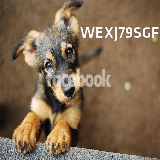

In [33]:
data_test[0]

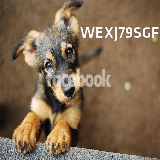

In [67]:
data_test[0]

In [68]:
res = learn_gen.predict(data_test[0])

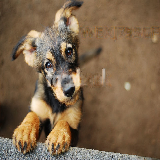

In [69]:
res[0]